In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs, reduce_variance, reduce_min, reduce_max
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from utils.basic_units import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [2]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
k = 10 # Top 10% highest l2-magnitude filters

In [4]:
def get_F_angle(F):
	
	F = tf.expand_dims(F, -1)
	_, a = getSymAntiSymTF(F)
	a_mag = reduce_euclidean_norm(a, axis=[0,1])[:, 0]
	theta = getSobelTF(F)[:, 0]
	#print(a_mag.shape)
	x =a_mag*np.cos((theta))
	y = a_mag*np.sin((theta))


	cov = np.cov([x,y])
	e_val, e_vec = np.linalg.eigh(cov)
	e_vec = e_vec[:, np.argmax(e_val)]
	e_val = np.max(e_val)

	new_vec =    ((e_vec[0] * x + e_vec[1]*y)/(e_vec[0]**2+e_vec[1]**2))[:, None] * e_vec
	new_vec = np.mean(new_vec, axis=0)


	return np.arctan2(new_vec[1], new_vec[0])

FL (3, 3, 64, 64)
(64, 3, 3, 3) (64, 3, 3, 3) (64, 3, 3, 3)
(64, 3, 3, 64) (64, 3, 3, 64) (64, 3, 3, 64)
AMAG (64, 64)
(64, 3, 3, 3) (64, 3, 3, 3) (64, 3, 3, 3)
[-3.14159265 -1.57079633  0.          1.57079633  3.14159265]
['-1.0π', '-0.5π', '0', '0.5π', '1.0π']
['-$\\pi$', '-$\\pi/2$', '0', '$\\pi/2$', '$\\pi$']
FL (3, 3, 64, 128)
(64, 3, 3, 64) (64, 3, 3, 64) (64, 3, 3, 64)
(128, 3, 3, 64) (128, 3, 3, 64) (128, 3, 3, 64)
AMAG (64, 128)
(64, 3, 3, 64) (64, 3, 3, 64) (64, 3, 3, 64)
[-3.14159265 -1.57079633  0.          1.57079633  3.14159265]
['-1.0π', '-0.5π', '0', '0.5π', '1.0π']
['-$\\pi$', '-$\\pi/2$', '0', '$\\pi/2$', '$\\pi$']
FL (3, 3, 128, 128)
(128, 3, 3, 64) (128, 3, 3, 64) (128, 3, 3, 64)
(128, 3, 3, 128) (128, 3, 3, 128) (128, 3, 3, 128)
AMAG (128, 128)
(128, 3, 3, 64) (128, 3, 3, 64) (128, 3, 3, 64)
[-3.14159265 -1.57079633  0.          1.57079633  3.14159265]
['-1.0π', '-0.5π', '0', '0.5π', '1.0π']
['-$\\pi$', '-$\\pi/2$', '0', '$\\pi/2$', '$\\pi$']


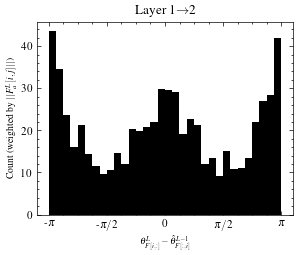

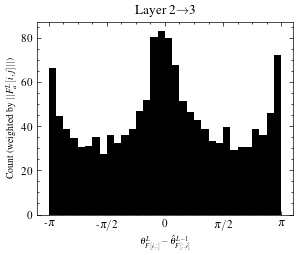

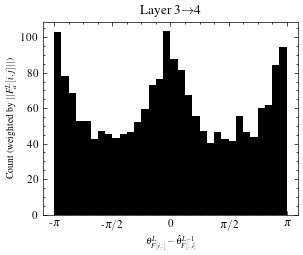

In [5]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)

for l_num in range(1, 4):
	#top10Fprev=topKfilters(model, l_num-1, k=20)
	filtersLprev = get_filter(model, l_num-1)#[:,:,:,top10Fprev]
	#top10F=topKfilters(model, l_num, k=20)
	filtersL = get_filter(model, l_num)#[:,:,:,top10F]
	filtersL = filtersL


	print("FL", filtersL.shape)

	# Get kernels magnitude and theta for layer L-1
	sp, ap = getSymAntiSymTF(filtersLprev)
	e_ap = reduce_euclidean_norm(ap, axis=[0,1])**2
	e_sp = reduce_euclidean_norm(sp, axis=[0,1])**2
	betap = e_ap/(e_ap+e_sp)


	# Get kernels magnitude and theta for layer L
	s, a = getSymAntiSymTF(filtersL)
	e_a = reduce_euclidean_norm(a, axis=[0,1])**2
	e_s = reduce_euclidean_norm(s, axis=[0,1])**2
	dc = np.sign(np.mean(filtersL, axis=(0,1)))

	beta = e_a/(e_a+e_s)



	e = reduce_euclidean_norm(filtersL, axis=[0,1])
	a_mag = reduce_euclidean_norm(a, axis=[0,1]).numpy()
	theta = getSobelTF(filtersL)
	
	#mag = (e_a - reduce_min(e_a, axis=0, keepdims=True))/(reduce_max(e_a, axis=0, keepdims=True) - reduce_min(e_a, axis=0, keepdims=True))
	mag = (a_mag - reduce_min(a_mag, axis=0, keepdims=True))/(reduce_max(a_mag, axis=0, keepdims=True) - reduce_min(a_mag, axis=0, keepdims=True))
	print("AMAG", mag.shape)


	#find lims :
	cos_sim = []
	m = []
	weight = []
	theta_F_prev = []
	_, theta_F_prev = getDominantAngle(filtersLprev)
	'''for i in range(filtersLprev.shape[-1]):
		theta_F_prev.append(get_F_angle(filtersLprev[:,:,:,i]))
	theta_F_prev = np.array(theta_F_prev)'''
	for i in range(filtersL.shape[-1]):
		#: = tf.where(tf.greater(dc[:, i],0))[:,0].numpy()
		mag = (a_mag[:,i]**2 - reduce_min(a_mag[:,i]**2 , axis=0, keepdims=True))/(reduce_max(a_mag[:,i]**2 , axis=0, keepdims=True) - reduce_min(a_mag[:,i]**2 , axis=0, keepdims=True))
		#print((theta_F_prev[:] - theta[:,i]).shape, mag.shape )
		cos_sim.extend(theta_F_prev - theta[:,i])#(np.cos(theta_F_prev - theta[i,:])))
		m.extend(mag.numpy())
		weight.extend((e[:,i]**2 - reduce_min(e[:,i]**2 , axis=0, keepdims=True))/(reduce_max(e[:,i]**2 , axis=0, keepdims=True) - reduce_min(e[:,i]**2 , axis=0, keepdims=True)))
	weight = np.array(weight)
	m = np.array(m)


	fig, ax= plt.subplots(1,1)

	data = np.array(cos_sim)
	data  = np.arctan2(np.sin(data), np.cos(data)) # (np.array(cos_sim) + np.pi) % (2 * np.pi) - np.pi

	data_min, data_max = np.min(data), np.max(data)


	ax.hist(data, bins=32, weights=m)

	data_min, data_max = np.min(data), np.max(data)

	# Set the tick marks at intervals of π
	tick_min = np.floor(data_min / np.pi) * np.pi  # Start at the lowest multiple of π
	tick_max = np.ceil(data_max / np.pi) * np.pi    # End at the highest multiple of π
	ticks = np.arange(tick_min, tick_max + np.pi/2, np.pi/2)  # Ticks spaced by π
	print(ticks)
	# Format tick labels with π notation
	labels = [f"{t / np.pi}π" if t != 0 else "0" for t in ticks]
	print(labels)
	labels = [label.replace("π", "$\\pi$").replace("1.0$\\pi$", "$\\pi$").replace("0.5$\\pi$", "$\\pi/2$") for label in labels]
	print(labels)
	# Set ticks and labels on the x-axis
	ax.set_xticks(ticks=ticks, labels=labels)




	#ax.convert_xunits(radians)
	ax.set_ylabel(r"Count (weighted by $||F^L_a{[i,j]}||$)", fontsize=7)
	#ax.set_ylabel(r"Count", fontsize=7)
	ax.set_xlabel(r"$\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]}$", fontsize=7)
	ax.set_title(f"Layer {l_num}"+r"$\rightarrow$"+f"{l_num+1}")
	fig.savefig(f"figures/vgg16/vgg16_orr_sim_layer_{l_num}.pdf", bbox_inches='tight', dpi=600)



(array([157.81851196, 112.43891907,  88.81433105,  85.33795166,
         82.853302  ,  87.57333374, 116.50956726, 169.3765564 ,
        157.41795349, 118.18161774,  86.37372589,  80.04821777,
         91.46173096,  80.67520142, 105.16244507, 160.80607605]),
 array([-3.1410987e+00, -2.7484617e+00, -2.3558249e+00, -1.9631879e+00,
        -1.5705509e+00, -1.1779140e+00, -7.8527713e-01, -3.9264017e-01,
        -3.2186508e-06,  3.9263374e-01,  7.8527069e-01,  1.1779076e+00,
         1.5705445e+00,  1.9631815e+00,  2.3558185e+00,  2.7484553e+00,
         3.1410923e+00], dtype=float32),
 <BarContainer object of 16 artists>)

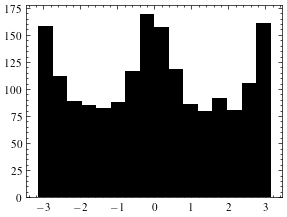

In [6]:
plt.hist(data, bins=16, weights=weight)